# exp10: OOF予測値の相関分析（Best Optunaパラメータ使用）


In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

In [2]:
# ============================================================================
# Best Optuna Parameters (from exp05 optimization)
# ============================================================================

BEST_PARAMS = {
    'Ridge': {'alpha': 70.4183028501599},
    'RandomForest': {
        'n_estimators': 261,
        'max_depth': 21,
        'min_samples_split': 13,
        'min_samples_leaf': 1,
        'max_features': None
    },
    'ExtraTrees': {
        'n_estimators': 229,
        'max_depth': 29,
        'min_samples_split': 16,
        'min_samples_leaf': 1,
        'max_features': None
    },
    'GradientBoosting': {
        'n_estimators': 477,
        'learning_rate': 0.26835579181051533,
        'max_depth': 2,
        'min_samples_split': 5,
        'min_samples_leaf': 1,
        'subsample': 0.9721678101451118
    },
    'HistGradientBoosting': {
        'max_iter': 238,
        'learning_rate': 0.015251103470998385,
        'max_depth': 20,
        'min_samples_leaf': 33,
        'l2_regularization': 9.037967498117355
    },
    'XGBoost': {
        'n_estimators': 4666,
        'learning_rate': 0.18057598957444881,
        'max_depth': 5,
        'subsample': 0.7726782988943871,
        'colsample_bytree': 0.6039221062901661,
        'reg_lambda': 0.9814360532884759,
        'reg_alpha': 1.6016986762895833
    },
    'LightGBM': {
        'n_estimators': 127,
        'learning_rate': 0.1601531217136121,
        'num_leaves': 112,
        'max_depth': 12,
        'subsample': 0.9085081386743783,
        'colsample_bytree': 0.6296178606936361,
        'reg_lambda': 0.5211124595788266,
        'reg_alpha': 0.5793452976256486
    },
    'CatBoost': {
        'iterations': 2295,
        'learning_rate': 0.10429705988762059,
        'depth': 5,
        'l2_leaf_reg': 6.359326196557493,
        'subsample': 0.8738193035765242
    }
}

print('Best parameters loaded from exp05 optimization')


Best parameters loaded from exp05 optimization


In [3]:
# ==================================================================================
# Step 1: データの読み込みと前処理
# ==================================================================================

def load_and_preprocess_data():
    """
    各データセットを読み込み、日付型に変換
    """
    print("=" * 80)
    print("Step 1: データの読み込み")
    print("=" * 80)
    
    # データ読み込み
    calender = pd.read_csv('../input/calender_data.csv')
    cm_data = pd.read_csv('../input/cm_data.csv')
    gt_service = pd.read_csv('../input/gt_service_name.csv')
    acc_get = pd.read_csv('../input/regi_acc_get_data_transform.csv')
    call_data = pd.read_csv('../input/regi_call_data_transform.csv')
    
    # 日付カラムをdatetime型に変換
    calender['cdr_date'] = pd.to_datetime(calender['cdr_date'])
    cm_data['cdr_date'] = pd.to_datetime(cm_data['cdr_date'])
    acc_get['cdr_date'] = pd.to_datetime(acc_get['cdr_date'])
    call_data['cdr_date'] = pd.to_datetime(call_data['cdr_date'])
    gt_service['week'] = pd.to_datetime(gt_service['week'])
    
    print(f"\nカレンダーデータ: {calender.shape}")
    print(f"CMデータ: {cm_data.shape}")
    print(f"Google Trendsデータ: {gt_service.shape}")
    print(f"アカウント取得データ: {acc_get.shape}")
    print(f"入電データ（目的変数）: {call_data.shape}")
    
    return calender, cm_data, gt_service, acc_get, call_data

In [4]:
# ==================================================================================
# Step 2: データの統合
# ==================================================================================

def merge_datasets(calender, cm_data, gt_service, acc_get, call_data):
    """
    全てのデータセットを統合
    Google Trendsは週次データなので日次に展開
    """
    print("\n" + "=" * 80)
    print("Step 2: データの統合")
    print("=" * 80)
    
    # メインデータ（入電数）を基準にマージ
    df = call_data.copy()
    print(f"\nベースデータ: {df.shape}")
    
    # カレンダー情報をマージ
    df = df.merge(calender, on='cdr_date', how='left')
    print(f"カレンダー情報マージ後: {df.shape}")
    
    # CM情報をマージ
    df = df.merge(cm_data, on='cdr_date', how='left')
    print(f"CM情報マージ後: {df.shape}")
    
    # アカウント取得数をマージ
    df = df.merge(acc_get, on='cdr_date', how='left')
    print(f"アカウント取得数マージ後: {df.shape}")
    
    # Google Trendsデータは週次なので日次に展開
    print("\nGoogle Trendsデータを週次→日次に展開...")
    gt_service_daily = []
    for idx, row in gt_service.iterrows():
        week_start = row['week']
        for i in range(7):
            date = week_start + timedelta(days=i)
            gt_service_daily.append({
                'cdr_date': date, 
                'search_cnt': row['search_cnt']
            })
    
    gt_daily = pd.DataFrame(gt_service_daily)
    df = df.merge(gt_daily, on='cdr_date', how='left')
    print(f"Google Trendsマージ後: {df.shape}")
    
    # 欠損値の確認
    print("\n欠損値の数:")
    print(df.isnull().sum().sort_values(ascending=False).head(10))
    
    return df

In [5]:
# ==================================================================================
# Step 3: 基本的な時系列特徴量の作成
# ==================================================================================

def create_basic_time_features(df):
    """
    日付から派生する基本的な時系列特徴量を作成
    これらは未来の情報を使わないので安全
    """
    print("\n" + "=" * 80)
    print("Step 3: 基本的な時系列特徴量の作成")
    print("=" * 80)
    
    df = df.copy()
    
    # 年月日の特徴量
    df['year'] = df['cdr_date'].dt.year
    df['month'] = df['cdr_date'].dt.month
    df['day_of_month'] = df['cdr_date'].dt.day
    df['quarter'] = df['cdr_date'].dt.quarter
    df['day_of_year'] = df['cdr_date'].dt.dayofyear
    
    # 週の情報（既にwoy, womがあるが念のため）
    df['week_of_year'] = df['cdr_date'].dt.isocalendar().week
    
    # 経過日数（データの開始日からの日数）
    df['days_from_start'] = (df['cdr_date'] - df['cdr_date'].min()).dt.days
    
    # 曜日情報（既にdowがあるが確認）
    # dow: 1=月, 2=火, ..., 7=日
    
    # 月初・月末フラグ
    df['is_month_start'] = (df['day_of_month'] <= 5).astype(int)
    df['is_month_end'] = (df['day_of_month'] >= 25).astype(int)
    
    print("\n作成した基本特徴量:")
    time_features = ['year', 'month', 'day_of_month', 'quarter', 'day_of_year', 
                     'week_of_year', 'days_from_start', 'is_month_start', 'is_month_end']
    print(time_features)
    
    return df

In [6]:
# ==================================================================================
# Step 4: ラグ特徴量の作成（データリーケージに注意！）
# ==================================================================================

def create_lag_features(df, target_col='call_num', lags=[1, 2, 3, 5, 7, 14, 30]):
    """
    ラグ特徴量（過去のデータ）を作成
    
    重要: 
    - shift()を使って、未来の情報が混入しないようにする
    - lag=1は1日前のデータ、lag=7は7日前のデータ
    
    例: 
    日付        call_num    lag_1    lag_7
    2018-06-01    183        NaN      NaN
    2018-06-02      0        183      NaN
    2018-06-08     96         0       183  <- 7日前のデータ
    """
    print("\n" + "=" * 80)
    print("Step 4: ラグ特徴量の作成（データリーケージ防止）")
    print("=" * 80)
    
    df = df.copy()
    
    print(f"\n目的変数: {target_col}")
    print(f"作成するラグ: {lags}")
    
    for lag in lags:
        col_name = f'lag_{lag}'
        df[col_name] = df[target_col].shift(lag)
        print(f"  作成: {col_name} (shift={lag})")
    
    # 最初のN日はラグ特徴量がNaNになる
    print(f"\n注意: 最初の{max(lags)}日間はラグ特徴量がNaNになります")
    print(f"例: lag_30は最初の30日間がNaN")
    
    return df

In [7]:
# ==================================================================================
# Step 5: 移動平均特徴量の作成（データリーケージに注意！）
# ==================================================================================

def create_rolling_features(df, target_col='call_num', windows=[3, 7, 14, 30]):
    """
    移動平均・移動標準偏差を作成
    
    重要:
    - rolling().mean() を使う前に shift(1) を適用
    - これにより、当日のデータが移動平均に含まれない（リーケージ防止）
    
    例（window=3の場合）:
    日付        call_num    過去3日の平均
    2018-06-01    183        NaN
    2018-06-02      0        NaN
    2018-06-03      0        NaN
    2018-06-04    213        61.0  <- (183+0+0)/3 = 61.0
    """
    print("\n" + "=" * 80)
    print("Step 5: 移動平均特徴量の作成（データリーケージ防止）")
    print("=" * 80)
    
    df = df.copy()
    
    print(f"\n目的変数: {target_col}")
    print(f"移動平均ウィンドウ: {windows}")
    
    for window in windows:
        # 移動平均（当日を含まない＝shift(1)してからrolling）
        ma_col = f'ma_{window}'
        df[ma_col] = df[target_col].shift(1).rolling(window=window, min_periods=1).mean()
        print(f"  作成: {ma_col} (過去{window}日間の平均)")
        
        # 移動標準偏差（変動の大きさを捉える）
        std_col = f'ma_std_{window}'
        df[std_col] = df[target_col].shift(1).rolling(window=window, min_periods=1).std()
        print(f"  作成: {std_col} (過去{window}日間の標準偏差)")
    
    print("\nなぜshift(1)が必要か:")
    print("  × 悪い例: rolling(3).mean() → 当日含む3日間の平均（リーケージ！）")
    print("  ○ 良い例: shift(1).rolling(3).mean() → 過去3日間の平均（安全）")
    
    return df

In [8]:
# ==================================================================================
# Step 6: その他の集約特徴量
# ==================================================================================

def create_aggregated_features(df):
    """
    その他の有用な集約特徴量を作成
    """
    print("\n" + "=" * 80)
    print("Step 6: その他の集約特徴量")
    print("=" * 80)
    
    df = df.copy()
    
    # CM効果の累積（過去7日間のCM実施回数）
    # これも当日を含まないようにshift(1)
    df['cm_7d'] = df['cm_flg'].shift(1).rolling(window=7, min_periods=1).sum()
    print("  作成: cm_7d (過去7日間のCM実施回数)")
    
    # Google Trendsの移動平均（ノイズ除去）
    df['gt_ma_7'] = df['search_cnt'].shift(1).rolling(window=7, min_periods=1).mean()
    print("  作成: gt_ma_7 (過去7日間のGoogle Trends平均)")
    
    # アカウント取得数の移動平均
    df['acc_ma_7'] = df['acc_get_cnt'].shift(1).rolling(window=7, min_periods=1).mean()
    print("  作成: acc_ma_7 (過去7日間のアカウント取得平均)")
    
    # 曜日ごとの過去平均（同じ曜日の過去データの平均）
    # これは少し高度だが、曜日パターンを捉えるのに有効
    print("\n  作成中: dow_avg (同じ曜日の過去平均)...")
    df['dow_avg'] = np.nan
    for dow in df['dow'].unique():
        mask = df['dow'] == dow
        # 各行について、その行より前のデータの平均を計算
        df.loc[mask, 'dow_avg'] = df.loc[mask, 'call_num'].shift(1).expanding().mean()
    
    return df

In [9]:
# ==================================================================================
# Step 7: 特徴量の選択とデータ分割（翌日予測に変更）
# ==================================================================================

def select_features_and_split(df, test_months=3):
    """
    特徴量を選択し、訓練データとテストデータに分割
    
    重要: 時系列データは時間順に分割する
    **exp03変更点**: 目的変数を call_num.shift(-1) に変更（翌日予測）
    """
    print("\n" + "=" * 80)
    print("Step 7: 特徴量選択とデータ分割")
    print("=" * 80)
    
    # 🚨 exp03変更点: 翌日の入電数を目的変数にする
    df = df.copy()
    df['target_next_day'] = df['call_num'].shift(-1)
    print("\n🎯 exp05: 目的変数を翌日の入電数に設定 (call_num.shift(-1))")
    
    # 最後の行はtargetがNaNになるので削除
    df = df.dropna(subset=['target_next_day']).reset_index(drop=True)
    print(f"翌日データがない最終行を削除: {len(df)}行")
    
    # 平日のみを使用（土日は入電数が0なので予測不要）
    df_model = df[df['dow'].isin([1, 2, 3, 4, 5])].copy().reset_index(drop=True)
    print(f"\n平日のみに絞り込み: {len(df)} → {len(df_model)}行")
    
    # 特徴量リスト（exp01と同じ）
    feature_cols = [
        # 基本的な時系列特徴量
        'dow', 'day_of_month', 'month', 'quarter', 'year', 
        'days_from_start', 'day_of_year', 'week_of_year',
        'is_month_start', 'is_month_end',
        
        # カレンダー特徴量
        'woy', 'wom', 'day_before_holiday_flag',
        
        # 外部データ
        'cm_flg', 'acc_get_cnt', 'search_cnt',
        
        # 集約特徴量
        'cm_7d', 'gt_ma_7', 'acc_ma_7', 'dow_avg',
        
        # ラグ特徴量
        'lag_1', 'lag_2', 'lag_3', 'lag_5', 'lag_7', 'lag_14', 'lag_30',
        
        # 移動平均特徴量
        'ma_3', 'ma_7', 'ma_14', 'ma_30',
        'ma_std_3', 'ma_std_7', 'ma_std_14', 'ma_std_30'
    ]
    
    print(f"\n使用する特徴量数: {len(feature_cols)}")
    print("\n特徴量のカテゴリ:")
    print(f"  - 基本時系列: 10個")
    print(f"  - カレンダー: 3個")
    print(f"  - 外部データ: 3個")
    print(f"  - 集約特徴量: 4個")
    print(f"  - ラグ特徴量: 7個")
    print(f"  - 移動平均: 8個")
    
    # 時系列分割（最後の3ヶ月をテストデータ）
    split_date = df_model['cdr_date'].max() - pd.Timedelta(days=30*test_months)
    
    train_df = df_model[df_model['cdr_date'] < split_date].copy()
    test_df = df_model[df_model['cdr_date'] >= split_date].copy()
    
    print(f"\n時系列分割:")
    print(f"  訓練データ期間: {train_df['cdr_date'].min()} ~ {train_df['cdr_date'].max()}")
    print(f"  テストデータ期間: {test_df['cdr_date'].min()} ~ {test_df['cdr_date'].max()}")
    print(f"  訓練データ数: {len(train_df)}行")
    print(f"  テストデータ数: {len(test_df)}行")
    
    # 欠損値がある行を削除（ラグ特徴量の初期値等）
    train_clean = train_df.dropna(subset=feature_cols + ['target_next_day'])
    test_clean = test_df.dropna(subset=feature_cols + ['target_next_day'])
    
    print(f"\n欠損値除去後:")
    print(f"  訓練データ数: {len(train_clean)}行")
    print(f"  テストデータ数: {len(test_clean)}行")
    
    # X（特徴量）とy（目的変数）に分割
    X_train = train_clean[feature_cols]
    y_train = train_clean['target_next_day']  # 🚨 exp05: 翌日の値
    X_test = test_clean[feature_cols]
    y_test = test_clean['target_next_day']    # 🚨 exp05: 翌日の値
    
    # メタ情報も保存（日付など）
    train_meta = train_clean[['cdr_date', 'call_num', 'target_next_day']]
    test_meta = test_clean[['cdr_date', 'call_num', 'target_next_day']]
    
    return X_train, X_test, y_train, y_test, train_meta, test_meta, feature_cols

In [10]:
# ==================================================================================
# Step 8: 特徴量の重要度確認用関数
# ==================================================================================

def analyze_features(X_train, y_train, feature_cols):
    """
    特徴量の基本統計と相関を確認
    """
    print("\n" + "=" * 80)
    print("Step 8: 特徴量の分析")
    print("=" * 80)
    
    # 基本統計量
    print("\n特徴量の基本統計:")
    print(X_train.describe().T[['mean', 'std', 'min', 'max']].head(10))
    
    # 目的変数との相関
    print("\n目的変数（翌日入電数）との相関（上位10）:")
    correlations = pd.DataFrame({
        'feature': feature_cols,
        'correlation': [X_train[col].corr(y_train) for col in feature_cols]
    }).sort_values('correlation', ascending=False, key=abs)
    
    print(correlations.head(10))
    
    return correlations

In [11]:
# ==================================================================================
# メイン実行関数
# ==================================================================================

def main():
    """
    全ての処理を実行
    """
    print("\n")
    print("*" * 80)
    print("exp05: AirREGI ヘルプデスク 翌日入電予測 (Optuna最適化版)")
    print("*" * 80)
    
    # Step 1: データ読み込み
    calender, cm_data, gt_service, acc_get, call_data = load_and_preprocess_data()
    
    # Step 2: データ統合
    df = merge_datasets(calender, cm_data, gt_service, acc_get, call_data)
    
    # Step 3: 基本時系列特徴量
    df = create_basic_time_features(df)
    
    # Step 4: ラグ特徴量
    df = create_lag_features(df, target_col='call_num', lags=[1, 2, 3, 5, 7, 14, 30])
    
    # Step 5: 移動平均特徴量
    df = create_rolling_features(df, target_col='call_num', windows=[3, 7, 14, 30])
    
    # Step 6: その他集約特徴量
    df = create_aggregated_features(df)
    
    # Step 7: 特徴量選択とデータ分割（翌日予測版）
    X_train, X_test, y_train, y_test, train_meta, test_meta, feature_cols = \
        select_features_and_split(df, test_months=3)
    
    # Step 8: 特徴量分析
    correlations = analyze_features(X_train, y_train, feature_cols)
    
    # データ保存
    print("\n" + "=" * 80)
    print("データの保存")
    print("=" * 80)
    
    # output ディレクトリが存在しない場合は作成
    import os
    output_dir = '../output/exp05'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"  {output_dir} ディレクトリを作成しました")
    
    train_data = pd.concat([train_meta.reset_index(drop=True), 
                           X_train.reset_index(drop=True)], axis=1)
    test_data = pd.concat([test_meta.reset_index(drop=True), 
                          X_test.reset_index(drop=True)], axis=1)
    
    train_data.to_csv(f'{output_dir}/train_features.csv', index=False)
    test_data.to_csv(f'{output_dir}/test_features.csv', index=False)
    correlations.to_csv(f'{output_dir}/feature_correlations.csv', index=False)
    
    print("\n保存完了:")
    print(f"  - {output_dir}/train_features.csv")
    print(f"  - {output_dir}/test_features.csv")
    print(f"  - {output_dir}/feature_correlations.csv")
    
    print("\n" + "=" * 80)
    print("特徴量エンジニアリング完了！")
    print("=" * 80)
    print(f"\n訓練データ: {X_train.shape}")
    print(f"テストデータ: {X_test.shape}")
    print(f"特徴量数: {len(feature_cols)}")
    print(f"\n🎯 目的変数: 翌日の入電数 (call_num.shift(-1))")
    
    return df, X_train, X_test, y_train, y_test, feature_cols

In [12]:
# ==================================================================================
# 実行
# ==================================================================================

if __name__ == "__main__":
    df, X_train, X_test, y_train, y_test, feature_cols = main()



********************************************************************************
exp05: AirREGI ヘルプデスク 翌日入電予測 (Optuna最適化版)
********************************************************************************
Step 1: データの読み込み

カレンダーデータ: (670, 10)
CMデータ: (762, 2)
Google Trendsデータ: (109, 2)
アカウント取得データ: (701, 2)
入電データ（目的変数）: (670, 2)

Step 2: データの統合

ベースデータ: (670, 2)
カレンダー情報マージ後: (670, 11)
CM情報マージ後: (670, 12)
アカウント取得数マージ後: (670, 13)

Google Trendsデータを週次→日次に展開...
Google Trendsマージ後: (670, 14)

欠損値の数:
holiday_name               632
cdr_date                     0
call_num                     0
dow                          0
dow_name                     0
woy                          0
wom                          0
doy                          0
financial_year               0
day_before_holiday_flag      0
dtype: int64

Step 3: 基本的な時系列特徴量の作成

作成した基本特徴量:
['year', 'month', 'day_of_month', 'quarter', 'day_of_year', 'week_of_year', 'days_from_start', 'is_month_start', 'is_month_end']

Step 4: ラグ特徴量の

In [19]:
# ============================================================================
# Train/Validation Split for Model Training
# ============================================================================

# main()から返されたX_train, y_trainを使って、さらにTrain/Validationに分割
# ただし、時系列情報が必要なので、元のdfから日付情報を取得

# train_metaに日付情報が含まれているはずなので、それを使う
# または、X_trainとy_trainをシンプルに時系列で分割

from sklearn.model_selection import train_test_split

# 時系列データなので、最後の部分をvalidationとする
# 全体の約15%（60日/391日）をvalidationに
val_size = int(len(X_train) * 0.15)
train_size = len(X_train) - val_size

X_tr = X_train.iloc[:train_size].copy()
y_tr = y_train.iloc[:train_size].copy()
X_va = X_train.iloc[train_size:].copy()
y_va = y_train.iloc[train_size:].copy()

print(f"Training set: {X_tr.shape}")
print(f"Validation set: {X_va.shape}")

# test_dfも定義（submission用）
test_df = X_test.copy()
# IDカラムがない場合は作成
if 'id' not in test_df.columns:
    test_df['id'] = range(len(test_df))

Training set: (333, 35)
Validation set: (58, 35)


---
## Model Training with Best Parameters


In [20]:
# ============================================================================
# Model Training with Best Parameters (OOF predictions saved)
# ============================================================================

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error

trained_models = {}
oof_predictions = {}  # OOF予測値を保存

print('\n' + '='*80)
print('Training models with best parameters...')
print('='*80)

# Ridge
print('\n[Ridge]')
model = Ridge(**BEST_PARAMS['Ridge'], random_state=42)
model.fit(X_tr, y_tr)
y_pred_val = model.predict(X_va)
mae = mean_absolute_error(y_va, y_pred_val)
print(f'Validation MAE: {mae:.4f}')
trained_models['Ridge (Best)'] = model
oof_predictions['Ridge'] = y_pred_val

# RandomForest
print('\n[RandomForest]')
model = RandomForestRegressor(**BEST_PARAMS['RandomForest'], random_state=42, n_jobs=-1)
model.fit(X_tr, y_tr)
y_pred_val = model.predict(X_va)
mae = mean_absolute_error(y_va, y_pred_val)
print(f'Validation MAE: {mae:.4f}')
trained_models['RandomForest (Best)'] = model
oof_predictions['RandomForest'] = y_pred_val

# ExtraTrees
print('\n[ExtraTrees]')
model = ExtraTreesRegressor(**BEST_PARAMS['ExtraTrees'], random_state=42, n_jobs=-1)
model.fit(X_tr, y_tr)
y_pred_val = model.predict(X_va)
mae = mean_absolute_error(y_va, y_pred_val)
print(f'Validation MAE: {mae:.4f}')
trained_models['ExtraTrees (Best)'] = model
oof_predictions['ExtraTrees'] = y_pred_val

# GradientBoosting
print('\n[GradientBoosting]')
model = GradientBoostingRegressor(**BEST_PARAMS['GradientBoosting'], random_state=42)
model.fit(X_tr, y_tr)
y_pred_val = model.predict(X_va)
mae = mean_absolute_error(y_va, y_pred_val)
print(f'Validation MAE: {mae:.4f}')
trained_models['GradientBoosting (Best)'] = model
oof_predictions['GradientBoosting'] = y_pred_val

# HistGradientBoosting
print('\n[HistGradientBoosting]')
model = HistGradientBoostingRegressor(**BEST_PARAMS['HistGradientBoosting'], random_state=42)
model.fit(X_tr, y_tr)
y_pred_val = model.predict(X_va)
mae = mean_absolute_error(y_va, y_pred_val)
print(f'Validation MAE: {mae:.4f}')
trained_models['HistGradientBoosting (Best)'] = model
oof_predictions['HistGradientBoosting'] = y_pred_val

# XGBoost
print('\n[XGBoost]')
model = XGBRegressor(**BEST_PARAMS['XGBoost'], random_state=42, n_jobs=-1)
model.fit(X_tr, y_tr)
y_pred_val = model.predict(X_va)
mae = mean_absolute_error(y_va, y_pred_val)
print(f'Validation MAE: {mae:.4f}')
trained_models['XGBoost (Best)'] = model
oof_predictions['XGBoost'] = y_pred_val

# LightGBM
print('\n[LightGBM]')
model = LGBMRegressor(**BEST_PARAMS['LightGBM'], random_state=42, n_jobs=-1, verbose=-1)
model.fit(X_tr, y_tr)
y_pred_val = model.predict(X_va)
mae = mean_absolute_error(y_va, y_pred_val)
print(f'Validation MAE: {mae:.4f}')
trained_models['LightGBM (Best)'] = model
oof_predictions['LightGBM'] = y_pred_val

# CatBoost
print('\n[CatBoost]')
model = CatBoostRegressor(**BEST_PARAMS['CatBoost'], random_state=42, verbose=0)
model.fit(X_tr, y_tr)
y_pred_val = model.predict(X_va)
mae = mean_absolute_error(y_va, y_pred_val)
print(f'Validation MAE: {mae:.4f}')
trained_models['CatBoost (Best)'] = model
oof_predictions['CatBoost'] = y_pred_val

print('\n' + '='*80)
print('All models trained successfully!')
print(f'Total models: {len(trained_models)}')
print('='*80)



Training models with best parameters...

[Ridge]
Validation MAE: 96.4442

[RandomForest]
Validation MAE: 65.1481

[ExtraTrees]
Validation MAE: 60.0663

[GradientBoosting]
Validation MAE: 70.9140

[HistGradientBoosting]
Validation MAE: 85.9830

[XGBoost]
Validation MAE: 73.3909

[LightGBM]
Validation MAE: 85.9878

[CatBoost]
Validation MAE: 75.7975

All models trained successfully!
Total models: 8



OOF Predictions DataFrame:
        Ridge  RandomForest  ExtraTrees  GradientBoosting  \
0  131.733277    261.831617  296.448376        234.339482   
1   80.291225      3.032567    0.000000        -26.875169   
2  221.854130    232.349803  261.812203        248.925390   
3  207.442270    230.381112  245.522603        216.553272   
4  169.852973    236.879324  243.869105        195.072712   

   HistGradientBoosting     XGBoost    LightGBM    CatBoost  
0            237.922010  200.497314  207.082062  207.671097  
1             83.079031    1.568133   47.469497   13.938479  
2            307.286980  212.298737  254.453911  224.721877  
3            270.490189  174.414307  265.111445  202.188262  
4            271.245313  181.698380  265.025091  217.374118  

Shape: (58, 8)

OOF Predictions Correlation Matrix
                       Ridge  RandomForest  ExtraTrees  GradientBoosting  \
Ridge                 1.0000        0.7394      0.6752            0.6740   
RandomForest          0.7394 

NameError: name 'output_dir' is not defined

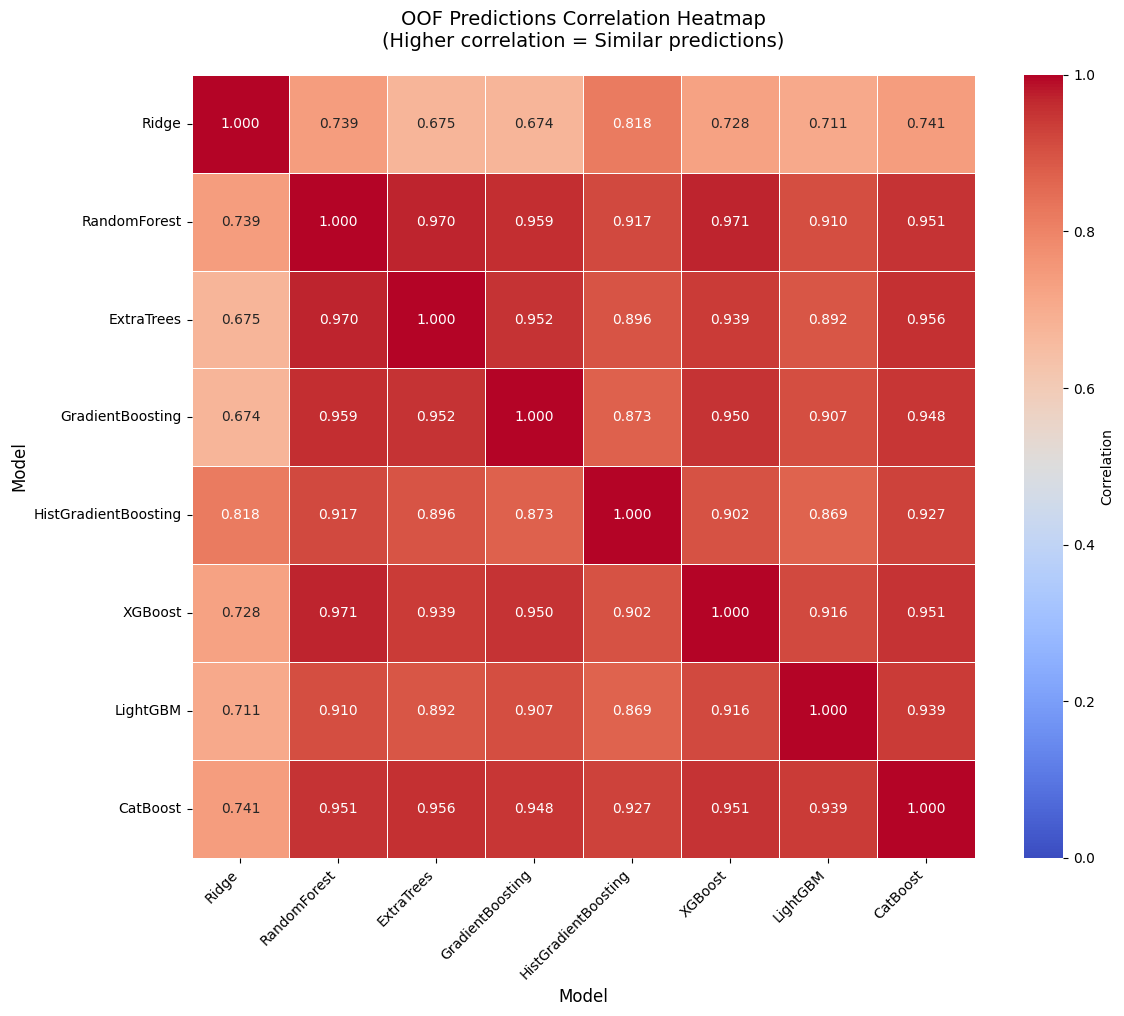

In [22]:
# ============================================================================
# OOF Predictions Correlation Analysis
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

# OOF予測値をDataFrameに変換
oof_df = pd.DataFrame(oof_predictions)

print('\nOOF Predictions DataFrame:')
print(oof_df.head())
print(f'\nShape: {oof_df.shape}')

# 相関行列を計算
correlation_matrix = oof_df.corr()

print('\n' + '='*80)
print('OOF Predictions Correlation Matrix')
print('='*80)
print(correlation_matrix.round(4))

# ヒートマップを作成
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            annot=True,  # 数値を表示
            fmt='.3f',   # 小数点3桁
            cmap='coolwarm',
            vmin=0, vmax=1,
            square=True,
            linewidths=0.5,
            cbar_kws={'label': 'Correlation'})
plt.title('OOF Predictions Correlation Heatmap\n(Higher correlation = Similar predictions)', 
          fontsize=14, pad=20)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(f'{output_dir}/oof_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'\nHeatmap saved to: {output_dir}/oof_correlation_heatmap.png')

# 相関行列をCSVで保存
correlation_matrix.to_csv(f'{output_dir}/oof_correlation_matrix.csv')
print(f'Correlation matrix saved to: {output_dir}/oof_correlation_matrix.csv')

# 各モデルのMAEも一緒に表示
print('\n' + '='*80)
print('Model Performance Summary')
print('='*80)
for model_name, pred in oof_predictions.items():
    mae = mean_absolute_error(y_va, pred)
    print(f'{model_name:25s} - MAE: {mae:8.4f}')


In [23]:
# ============================================================================
# Save OOF Scores Summary
# ============================================================================

# OOFスコアをまとめる
oof_scores = []
for model_name, pred in oof_predictions.items():
    mae = mean_absolute_error(y_va, pred)
    oof_scores.append({
        'Model': model_name,
        'OOF_MAE': mae
    })

oof_scores_df = pd.DataFrame(oof_scores)
oof_scores_df = oof_scores_df.sort_values('OOF_MAE').reset_index(drop=True)

print('\nOOF Scores Summary (sorted by MAE):')
print(oof_scores_df.to_string(index=False))

# CSV保存
oof_scores_df.to_csv(f'{output_dir}/oof_scores_summary.csv', index=False)
print(f'\nOOF scores saved to: {output_dir}/oof_scores_summary.csv')



OOF Scores Summary (sorted by MAE):
               Model   OOF_MAE
          ExtraTrees 60.066319
        RandomForest 65.148118
    GradientBoosting 70.914011
             XGBoost 73.390935
            CatBoost 75.797459
HistGradientBoosting 85.983007
            LightGBM 85.987800
               Ridge 96.444211


NameError: name 'output_dir' is not defined

In [24]:
# ============================================================================
# Test Predictions
# ============================================================================

test_predictions = {}

for model_name, model in trained_models.items():
    pred = model.predict(test_df[feature_cols])
    test_predictions[model_name] = pred
    print(f'{model_name}: {len(pred)} predictions made')

print(f'\nTotal models: {len(test_predictions)}')


Ridge (Best): 65 predictions made
RandomForest (Best): 65 predictions made
ExtraTrees (Best): 65 predictions made
GradientBoosting (Best): 65 predictions made
HistGradientBoosting (Best): 65 predictions made
XGBoost (Best): 65 predictions made
LightGBM (Best): 65 predictions made
CatBoost (Best): 65 predictions made

Total models: 8


In [25]:
# ============================================================================
# Create Submission Files
# ============================================================================

import os

for model_name, pred in test_predictions.items():
    submission = pd.DataFrame({
        'id': test_df['id'],
        'target_next_day': pred
    })
    
    # モデル名をファイル名に使用（スペースをアンダースコアに）
    safe_name = model_name.replace(' ', '_').replace('(', '').replace(')', '')
    filepath = f'{output_dir}/submission_{safe_name}.csv'
    
    submission.to_csv(filepath, index=False)
    print(f'Saved: {filepath}')

print('\nAll submission files created!')


NameError: name 'output_dir' is not defined

---
## SHAP Analysis


SHAP analysis on 58 samples...

[XGBoost SHAP]


NameError: name 'output_dir' is not defined

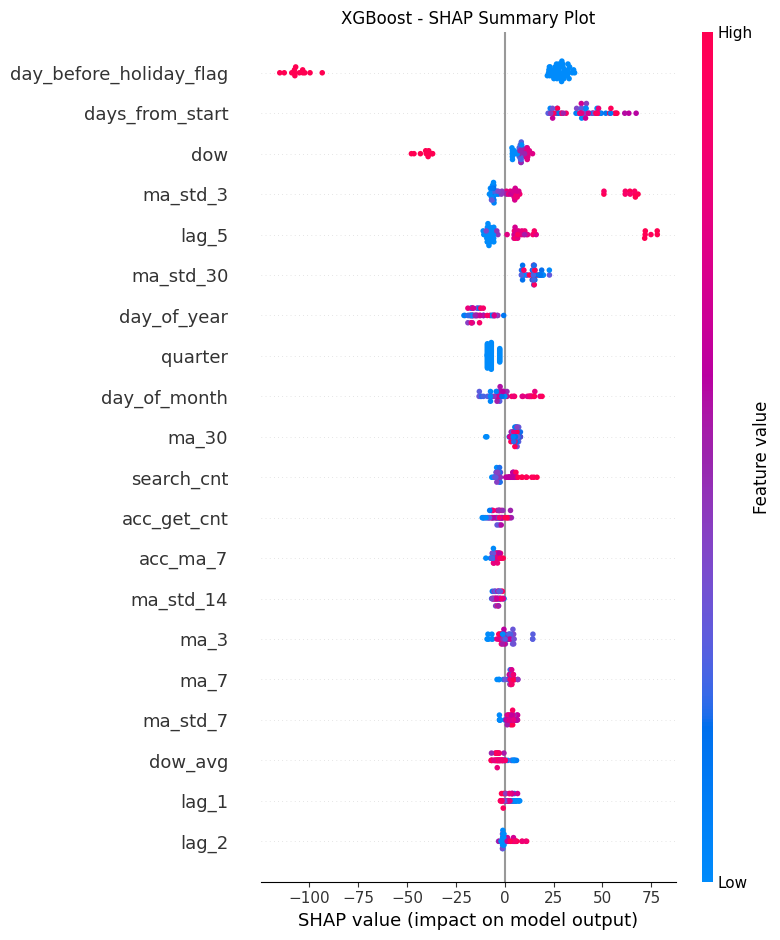

In [26]:
# ============================================================================
# SHAP Analysis (for key models)
# ============================================================================

import shap

# サンプル数を制限
sample_size = min(100, len(X_va))
X_explain = X_va.sample(n=sample_size, random_state=42)

print(f'SHAP analysis on {sample_size} samples...')

# XGBoost SHAP
if 'XGBoost (Best)' in trained_models:
    print('\n[XGBoost SHAP]')
    model = trained_models['XGBoost (Best)']
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_explain)
    
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_explain, show=False)
    plt.title('XGBoost - SHAP Summary Plot')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/shap_xgboost_summary.png', dpi=300, bbox_inches='tight')
    plt.show()

# CatBoost SHAP
if 'CatBoost (Best)' in trained_models:
    print('\n[CatBoost SHAP]')
    model = trained_models['CatBoost (Best)']
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_explain)
    
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_explain, show=False)
    plt.title('CatBoost - SHAP Summary Plot')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/shap_catboost_summary.png', dpi=300, bbox_inches='tight')
    plt.show()

print('\nSHAP analysis completed!')


---
## Summary

**exp10: OOF Predictions Correlation Analysis**

- ベースライン: exp05
- Best Optunaパラメータを使用
- 各モデルのOOF予測値の相関を分析
- 相関ヒートマップ（数値付き）を出力

### Key Outputs:
1. `oof_correlation_heatmap.png` - OOF予測値の相関ヒートマップ
2. `oof_correlation_matrix.csv` - 相関行列（CSV）
3. `oof_scores_summary.csv` - 各モデルのOOF MAE
4. Submission files for all models
